In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
home_dir = '/content/gdrive/My Drive/Colab Notebooks/newlogic'
import sys
sys.path.append(home_dir)

In [0]:
import os

In [0]:
# third-party library
import torch
import torch.nn as nn
from torch.nn.functional import one_hot
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
from models import CNN
from utils import grouper
from time import time

In [7]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Using device: %s" % device)

Using device: cuda


In [0]:
# Hyper Parameters
EPOCH = 2               # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 64
TEST_FREQ = 100
LR = 0.001              # learning rate
DOWNLOAD_MNIST = not(os.path.exists('./mnist/')) or not os.listdir('./mnist/')

In [9]:
gaussian_noise = torchvision.transforms.Lambda(lambda x : (x + torch.randn_like(x)*0.3)
                                                           .clamp(min=0, max=1))
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(size=(28, 28), scale=(0.9, 1.0)),
    torchvision.transforms.RandomRotation(degrees=10),
    torchvision.transforms.ToTensor(),
    gaussian_noise,
    torchvision.transforms.RandomErasing(scale=(0.01, 0.05))
])
train_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=True,
    transform=train_transform, 
    download=DOWNLOAD_MNIST,
)
test_data = torchvision.datasets.MNIST(
    root='./mnist/', 
    train=False, 
    transform=torchvision.transforms.ToTensor()
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 20738272.47it/s]                            


Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw


32768it [00:00, 331889.97it/s]
0it [00:00, ?it/s]

Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw


1654784it [00:00, 5889642.74it/s]                           
8192it [00:00, 120684.98it/s]


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw
Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


torch.Size([60000, 28, 28])
torch.Size([60000])


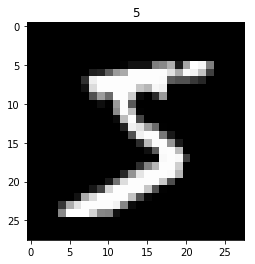

In [10]:
# plot one example
print(train_data.train_data.size())                 # (60000, 28, 28)
print(train_data.train_labels.size())               # (60000)
plt.imshow(train_data.train_data[0].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[0])
plt.show()

In [0]:
def train(name, timeout_sec=120, strictening=None, **kwargs):
    use_sigmoid_out = kwargs.get('use_sigmoid_out', False)
    torch.manual_seed(3582)    # reproducible    
    # Data Loader for easy mini-batch return in training, the image batch shape will be (BS, 1, 28, 28)
    train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = Data.DataLoader(dataset=test_data, batch_size=2000, shuffle=True)    
    cnn = CNN(**kwargs)
    print(cnn)  # net architecture
    optimizer = torch.optim.Adam(cnn.parameters(), amsgrad=True, lr=LR)   # okwargsize all cnn parameters
    loss_func = nn.MSELoss() if use_sigmoid_out else nn.CrossEntropyLoss()
    train_loop_with_timeout(cnn, train_loader, test_loader, optimizer, 
                            loss_func, use_sigmoid_out, strictening, timeout_sec)
    out_path = os.path.join(home_dir, 'output/%s.pkl' % name)
    torch.save(cnn, out_path)
    print('Model saved to %s' % out_path)
    return cnn
    
def train_loop_with_timeout(cnn, train_loader, test_loader, optimizer, 
                            loss_func, use_sigmoid_out, strictening, timeout_sec):
    cnn.to(device)
    started_sec = time()
    for epoch in range(EPOCH):
        batch_groups = grouper(train_loader, TEST_FREQ)
        for batch_group, (test_x, test_y) in zip(batch_groups, test_loader): 
            for train_x, train_y in batch_group:
                train_x = train_x.to(device)
                train_y = train_y.to(device)
                output, _ = cnn(train_x)
                if use_sigmoid_out:
                    train_y = one_hot(train_y, num_classes=10).float()
                    loss = loss_func(output, train_y)
                else:
                    loss = loss_func(output, train_y)
                if strictening is not None and strictening > 0:
                    modules = [cnn.conv1[0], cnn.conv2[0], cnn.out[0]]
                    weight_reg = sum(m.weight.abs().mean() for m in modules)
                    bias_reg = sum(m.bias.mean() for m in modules) # notice: no abs()
                    loss += strictening * (weight_reg + bias_reg)
                optimizer.zero_grad()           # clear gradients for this training step
                loss.backward()                 # backpropagation, compute gradients
                optimizer.step()                # apply gradients

            test_output, _ = cnn(test_x.to(device))
            pred_y = torch.max(test_output, 1)[1].cpu().data.numpy()
            accuracy = float((pred_y == test_y.data.numpy()).astype(int).sum()) / float(test_y.size(0))
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.cpu().data.numpy(), '| test accuracy: %.2f' % accuracy)
            
            elapsed_sec = time() - started_sec
            if elapsed_sec > timeout_sec:
                print('Timeout (%.2f sec), training is terminated' % elapsed_sec)
                return

In [10]:
%%time
_ = train('cnn-mnist-relu', use_relog=False, use_maxout=False,
          conv1_out_channels=16, conv2_out_channels=32)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Sequential(
    (0): Linear(in_features=1568, out_features=10, bias=True)
  )
)
Epoch:  0 | train loss: 0.5659 | test accuracy: 0.89
Epoch:  0 | train loss: 0.3762 | test accuracy: 0.93
Epoch:  0 | train loss: 0.1689 | test accuracy: 0.96
Epoch:  0 | train loss: 0.1939 | test accuracy: 0.96
Epoch:  0 | train loss: 0.1877 | test accuracy: 0.97
Epoch:  1 | train loss: 0.6079 | test accuracy: 0.97
Epoch:  1 | train loss: 0.1096 | test accuracy: 0.97
Epoch:  1 | train loss: 0.1221 | test accuracy: 0.97
Epoch:  1 | train loss: 0.1627 | test accuracy: 0.98
Epoch:  1 | train loss: 0.

In [11]:
%%time
_ = train('cnn-mnist-relu-strictening_0.01', use_relog=False, use_maxout=False,
          conv1_out_channels=16, conv2_out_channels=32, strictening=0.01)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Sequential(
    (0): Linear(in_features=1568, out_features=10, bias=True)
  )
)
Epoch:  0 | train loss: 0.7056 | test accuracy: 0.90
Epoch:  0 | train loss: 0.5152 | test accuracy: 0.94
Epoch:  0 | train loss: 0.2076 | test accuracy: 0.95
Epoch:  0 | train loss: 0.1586 | test accuracy: 0.96
Epoch:  0 | train loss: 0.2599 | test accuracy: 0.97
Epoch:  1 | train loss: 0.2606 | test accuracy: 0.97
Epoch:  1 | train loss: 0.1891 | test accuracy: 0.97
Epoch:  1 | train loss: 0.1776 | test accuracy: 0.97
Epoch:  1 | train loss: 0.2278 | test accuracy: 0.98
Epoch:  1 | train loss: 0.

In [12]:
%%time
_ = train('cnn-mnist-relu-strictening_0.1', use_relog=False, use_maxout=False,
          conv1_out_channels=16, conv2_out_channels=32, strictening=0.1)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Sequential(
    (0): Linear(in_features=1568, out_features=10, bias=True)
  )
)
Epoch:  0 | train loss: 0.7101 | test accuracy: 0.89
Epoch:  0 | train loss: 0.3180 | test accuracy: 0.93
Epoch:  0 | train loss: 0.2197 | test accuracy: 0.95
Epoch:  0 | train loss: 0.1462 | test accuracy: 0.96
Epoch:  0 | train loss: 0.0880 | test accuracy: 0.97
Epoch:  1 | train loss: 0.1925 | test accuracy: 0.97
Epoch:  1 | train loss: 0.1340 | test accuracy: 0.97
Epoch:  1 | train loss: 0.1483 | test accuracy: 0.97
Epoch:  1 | train loss: 0.1820 | test accuracy: 0.98
Epoch:  1 | train loss: 0.

In [13]:
%%time
_ = train('cnn-mnist-relu-strictening_5', use_relog=False, use_maxout=False,
          conv1_out_channels=16, conv2_out_channels=32, strictening=5)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Sequential(
    (0): Linear(in_features=1568, out_features=10, bias=True)
  )
)
Epoch:  0 | train loss: -0.4644 | test accuracy: 0.88
Epoch:  0 | train loss: -2.1540 | test accuracy: 0.91
Epoch:  0 | train loss: -3.8630 | test accuracy: 0.94
Epoch:  0 | train loss: -5.3628 | test accuracy: 0.94
Epoch:  0 | train loss: -6.9092 | test accuracy: 0.95
Epoch:  1 | train loss: -8.3125 | test accuracy: 0.96
Epoch:  1 | train loss: -9.9544 | test accuracy: 0.96
Epoch:  1 | train loss: -11.4203 | test accuracy: 0.96
Epoch:  1 | train loss: -12.7795 | test accuracy: 0.96
Epoch:  1 | tra

In [10]:
%%time
_ = train('cnn-mnist-relog', use_relog=True, use_maxout=False,
          conv1_out_channels=16, conv2_out_channels=32)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLog(n=100.00)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLog(n=100.00)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Sequential(
    (0): Linear(in_features=1568, out_features=10, bias=True)
  )
)
Epoch:  0 | train loss: 0.9238 | test accuracy: 0.85
Epoch:  0 | train loss: 0.5512 | test accuracy: 0.91
Epoch:  0 | train loss: 0.5100 | test accuracy: 0.93
Epoch:  0 | train loss: 0.3649 | test accuracy: 0.94
Epoch:  0 | train loss: 0.3154 | test accuracy: 0.95
Epoch:  1 | train loss: 0.3615 | test accuracy: 0.96
Epoch:  1 | train loss: 0.2893 | test accuracy: 0.96
Epoch:  1 | train loss: 0.2153 | test accuracy: 0.96
Epoch:  1 | train loss: 0.2709 | test accuracy: 0.96
Epoch:  

In [11]:
%%time
_ = train('cnn-mnist-relog-more-neurons', use_relog=True, use_maxout=False,
          conv1_out_channels=64, conv2_out_channels=128)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLog(n=100.00)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLog(n=100.00)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Sequential(
    (0): Linear(in_features=6272, out_features=10, bias=True)
  )
)
Epoch:  0 | train loss: 0.8085 | test accuracy: 0.78
Epoch:  0 | train loss: 0.5538 | test accuracy: 0.89
Epoch:  0 | train loss: 0.3215 | test accuracy: 0.91
Epoch:  0 | train loss: 0.3006 | test accuracy: 0.95
Epoch:  0 | train loss: 0.4091 | test accuracy: 0.93
Epoch:  1 | train loss: 0.3923 | test accuracy: 0.96
Epoch:  1 | train loss: 0.3043 | test accuracy: 0.96
Epoch:  1 | train loss: 0.2107 | test accuracy: 0.96
Epoch:  1 | train loss: 0.2214 | test accuracy: 0.96
Epoch: 

In [12]:
%%time
_ = train('cnn-mnist-relog-maxout', use_relog=True, use_maxout='max',
          conv1_out_channels=16, conv2_out_channels=32, max_folding_factor=4)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): FoldingMaxout(use_min=False, k=4)
    (2): ReLog(n=100.00)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): FoldingMaxout(use_min=False, k=4)
    (2): ReLog(n=100.00)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Sequential(
    (0): Linear(in_features=1568, out_features=40, bias=True)
    (1): FoldingMaxout(use_min=False, k=4)
  )
)
Epoch:  0 | train loss: 2.1842 | test accuracy: 0.47
Epoch:  0 | train loss: 1.0843 | test accuracy: 0.82
Epoch:  0 | train loss: 0.7169 | test accuracy: 0.88
Epoch:  0 | train loss: 0.4304 | test accuracy: 0.92
Epoch:  0 | train loss: 0.5399 | test accuracy: 0.92
Epoch:  1 | train loss: 0.2052 | test accuracy: 0.93
Epoch:  1 | train loss: 0.4023 | test

In [13]:
%%time
_ = train('cnn-mnist-relog-maxout-sigmoid-out', use_relog=True, 
          conv1_out_channels=16, conv2_out_channels=32, 
          use_maxout='max', max_folding_factor=4, use_sigmoid_out=True,
          timeout_sec=900)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): FoldingMaxout(use_min=False, k=4)
    (2): ReLog(n=100.00)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): FoldingMaxout(use_min=False, k=4)
    (2): ReLog(n=100.00)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Sequential(
    (0): Linear(in_features=1568, out_features=40, bias=True)
    (1): FoldingMaxout(use_min=False, k=4)
    (2): Sigmoid()
  )
)
Epoch:  0 | train loss: 0.0907 | test accuracy: 0.12
Epoch:  0 | train loss: 0.0816 | test accuracy: 0.44
Epoch:  0 | train loss: 0.0439 | test accuracy: 0.85
Epoch:  0 | train loss: 0.0270 | test accuracy: 0.93
Epoch:  0 | train loss: 0.0260 | test accuracy: 0.93
Epoch:  1 | train loss: 0.0175 | test accuracy: 0.94
Epoch:  1 | train 

In [14]:
%%time
_ = train('cnn-mnist-relog-minmaxout_4_2-sigmoid-out', use_relog=True, 
          conv1_out_channels=16, conv2_out_channels=32, 
          use_maxout='minmax', min_folding_factor=4, max_folding_factor=2, 
          use_sigmoid_out=True, timeout_sec=1200)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): FoldingMaxout(use_min=True, k=4)
    (2): FoldingMaxout(use_min=False, k=2)
    (3): ReLog(n=100.00)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): FoldingMaxout(use_min=True, k=4)
    (2): FoldingMaxout(use_min=False, k=2)
    (3): ReLog(n=100.00)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Sequential(
    (0): Linear(in_features=1568, out_features=80, bias=True)
    (1): FoldingMaxout(use_min=True, k=4)
    (2): FoldingMaxout(use_min=False, k=2)
    (3): Sigmoid()
  )
)
Epoch:  0 | train loss: 0.0491 | test accuracy: 0.82
Epoch:  0 | train loss: 0.0224 | test accuracy: 0.93
Epoch:  0 | train loss: 0.0192 | test accuracy: 0.96
Epoch:  0 | train loss: 0.0193 | test accuracy: 0.

In [15]:
%%time
_ = train('cnn-mnist-relog-minmaxout_4_2-sigmoid-out-strictening_1', use_relog=True, 
          conv1_out_channels=16, conv2_out_channels=32, 
          use_maxout='minmax', min_folding_factor=4, max_folding_factor=2,
          use_sigmoid_out=True, strictening=1, timeout_sec=1200)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): FoldingMaxout(use_min=True, k=4)
    (2): FoldingMaxout(use_min=False, k=2)
    (3): ReLog(n=100.00)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): FoldingMaxout(use_min=True, k=4)
    (2): FoldingMaxout(use_min=False, k=2)
    (3): ReLog(n=100.00)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Sequential(
    (0): Linear(in_features=1568, out_features=80, bias=True)
    (1): FoldingMaxout(use_min=True, k=4)
    (2): FoldingMaxout(use_min=False, k=2)
    (3): Sigmoid()
  )
)
Epoch:  0 | train loss: -0.1687 | test accuracy: 0.84
Epoch:  0 | train loss: -0.5089 | test accuracy: 0.92
Epoch:  0 | train loss: -0.8096 | test accuracy: 0.94
Epoch:  0 | train loss: -1.1045 | test accuracy

In [12]:
%%time
_ = train('cnn-mnist-relog-minmaxout_4_2-sigmoid-out-strictening_0.1', use_relog=True, 
          conv1_out_channels=16, conv2_out_channels=32, 
          use_maxout='minmax', min_folding_factor=4, max_folding_factor=2,
          use_sigmoid_out=True, strictening=0.1, timeout_sec=1200)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): FoldingMaxout(use_min=True, k=4)
    (2): FoldingMaxout(use_min=False, k=2)
    (3): ReLog(n=100.00)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): FoldingMaxout(use_min=True, k=4)
    (2): FoldingMaxout(use_min=False, k=2)
    (3): ReLog(n=100.00)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Sequential(
    (0): Linear(in_features=1568, out_features=80, bias=True)
    (1): FoldingMaxout(use_min=True, k=4)
    (2): FoldingMaxout(use_min=False, k=2)
    (3): Sigmoid()
  )
)
Epoch:  0 | train loss: 0.0459 | test accuracy: 0.78
Epoch:  0 | train loss: -0.0071 | test accuracy: 0.92
Epoch:  0 | train loss: -0.0311 | test accuracy: 0.95
Epoch:  0 | train loss: -0.0647 | test accuracy:

In [13]:
%%time
_ = train('cnn-mnist-relog-minmaxout_4_2-sigmoid-out-strictening_0.01', 
          use_relog=True, conv1_out_channels=16, conv2_out_channels=32, 
          use_maxout='minmax', min_folding_factor=4, max_folding_factor=2,
          use_sigmoid_out=True, strictening=0.01, timeout_sec=1200)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): FoldingMaxout(use_min=True, k=4)
    (2): FoldingMaxout(use_min=False, k=2)
    (3): ReLog(n=100.00)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): FoldingMaxout(use_min=True, k=4)
    (2): FoldingMaxout(use_min=False, k=2)
    (3): ReLog(n=100.00)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Sequential(
    (0): Linear(in_features=1568, out_features=80, bias=True)
    (1): FoldingMaxout(use_min=True, k=4)
    (2): FoldingMaxout(use_min=False, k=2)
    (3): Sigmoid()
  )
)
Epoch:  0 | train loss: 0.0520 | test accuracy: 0.80
Epoch:  0 | train loss: 0.0225 | test accuracy: 0.92
Epoch:  0 | train loss: 0.0159 | test accuracy: 0.95
Epoch:  0 | train loss: 0.0165 | test accuracy: 0.

In [14]:
%%time
_ = train('cnn-mnist-relog-minmaxout_4_2-sigmoid-out-strictening_0.001', 
          use_relog=True, conv1_out_channels=16, conv2_out_channels=32, 
          use_maxout='minmax', min_folding_factor=4, max_folding_factor=2,
          use_sigmoid_out=True, strictening=0.001, timeout_sec=1200)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): FoldingMaxout(use_min=True, k=4)
    (2): FoldingMaxout(use_min=False, k=2)
    (3): ReLog(n=100.00)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): FoldingMaxout(use_min=True, k=4)
    (2): FoldingMaxout(use_min=False, k=2)
    (3): ReLog(n=100.00)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Sequential(
    (0): Linear(in_features=1568, out_features=80, bias=True)
    (1): FoldingMaxout(use_min=True, k=4)
    (2): FoldingMaxout(use_min=False, k=2)
    (3): Sigmoid()
  )
)
Epoch:  0 | train loss: 0.0497 | test accuracy: 0.84
Epoch:  0 | train loss: 0.0217 | test accuracy: 0.93
Epoch:  0 | train loss: 0.0194 | test accuracy: 0.96
Epoch:  0 | train loss: 0.0186 | test accuracy: 0.

**Unused snipets**

In [0]:
# # following function (plot_with_labels) is for visualization, can be ignored if not interested
# from matplotlib import cm
# try: from sklearn.manifold import TSNE; HAS_SK = True
# except: HAS_SK = False; print('Please install sklearn for layer visualization')
# def plot_with_labels(lowDWeights, labels):
#     plt.cla()
#     X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
#     for x, y, s in zip(X, Y, labels):
#         c = cm.rainbow(int(255 * s / 9)); plt.text(x, y, s, backgroundcolor=c, fontsize=9)
#     plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer'); plt.show(); plt.pause(0.01)

# plt.ion()

# ...
#             if HAS_SK:
#                 # Visualization of trained flatten layer (T-SNE)
#                 tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
#                 plot_only = 500
#                 low_dim_embs = tsne.fit_transform(last_layer.data.numpy()[:plot_only, :])
#                 labels = test_y.numpy()[:plot_only]
#                 plot_with_labels(low_dim_embs, labels)
# plt.ioff()

In [0]:
# # print 10 predictions from test data
# test_output, _ = cnn(test_x[:10])
# pred_y = torch.max(test_output, 1)[1].data.numpy()
# print(pred_y, 'prediction number')
# print(test_y[:10].numpy(), 'real number')